- Sentimental Analysis on the data stored

In [1]:
import requests
from requests_oauthlib import OAuth1
from requests.models import Response
from time import sleep
import glob
import json
import os
import re
import tweepy
from textblob import TextBlob
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt

In [2]:
accesstoken=os.getenv('accesstoken')
accesstokensecret=os.getenv('accesstokensecret')
consumerkey=os.getenv('consumerkey')
consumersecret=os.getenv('consumersecret')
url='https://api.twitter.com/1.1/account/verify_credentials.json'
auth = OAuth1(consumerkey, consumersecret, accesstoken,accesstokensecret)
requests.get(url, auth=auth)

<Response [200]>

In [3]:
path='Final Project/Storing Data/'

Positive tweets percentage: 26.6152362584378 %
Negative tweets percentage: 14.657666345226616 %
Neutral tweets percentage: 58.72709739633558 % 


Positive tweets:
"It's young, but it's not JUST young. 50% of all daily new Snapchatters in the US are 25+" - @Cookseycc chats @Snapchat at #PubTechConnect
RT @FallonTonight: #TicketsAt12 time! Check our @Snapchat story to find out where our intern is hiding. First to find our intern wins 2 tix…
@Snapchat GOT RID OF MY FAVORITE FILTER. 😭😭😭😭BRING IT BACK!!! https://t.co/IX9jQxAwPr
@Snapchat Your rated the best on #appstore #snapchat gone down #boycottsnapchat 🖕🏾 https://t.co/Yh0QKO0pDr
@masonzyn @femwriter @GOtransitLE @GOtransitLW @GOtransit @Snapchat If I can find some, the first many I didn't log in
RT @Manoj1418: @TheQuint @Snapchat thanks for telling us, we will develop such platform inhouse " make in India" 🇮🇳 u stay rich
@Snapchat I love you, you're my favourite app.. BUT fuck, why did you have to translate your snapchat stories ?!?… ht

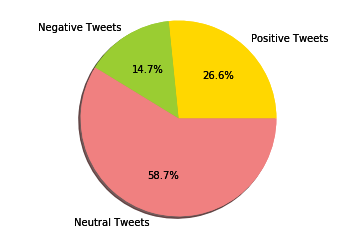

In [6]:
import re
from textblob import TextBlob

ptweetsperc=0.0
ntweetsperc=0.0
netweetsperc=0.0

tweets = []
my_tweet_dict = {}


def preprocess_tweet(tweet):
       return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())
 
def tweet_sentiment(tweet):
        cleaned_tweet = TextBlob(preprocess_tweet(tweet))
        if cleaned_tweet.sentiment.polarity > 0:
            return 'positive'
        elif cleaned_tweet.sentiment.polarity == 0:
            return 'neutral'
        else:
            return 'negative'

def get_tweets():
    try:
        for filename in glob.glob(os.path.join(path, '*.json')):
            with open(filename) as f:
                data = json.load(f)
                fetched_tweets = data
                for tweet in fetched_tweets:
                    my_tweet_dict = {}
                    txt=fetched_tweets[tweet]['text']
                    my_tweet_dict['text'] = txt
                    my_tweet_dict['sentiment'] = tweet_sentiment(txt)
            
                    recount=fetched_tweets[tweet]['retweet_count']
                    if recount > 0:
                        if my_tweet_dict not in tweets:
                            tweets.append(my_tweet_dict)
                    else:
                        tweets.append(my_tweet_dict)
        return tweets
    except tweepy.TweepError as e:
            print("Error : " + str(e))

def sentimental_analysis():
    tweets = get_tweets()
    global ptweetsperc
    
    ptweets = [tweet for tweet in tweets if tweet['sentiment'] == 'positive']
    ptweetsperc = (100*len(ptweets)/len(tweets))
    print("Positive tweets percentage: {} %".format(100*len(ptweets)/len(tweets)))
    
    global ntweetsperc
    ntweets = [tweet for tweet in tweets if tweet['sentiment'] == 'negative']
    ntweetsperc=(100*len(ntweets)/len(tweets))
    print("Negative tweets percentage: {} %".format(100*len(ntweets)/len(tweets)))

    global netweetsperc
    netweets = [tweet for tweet in tweets if tweet['sentiment'] == 'neutral']
    netweetsperc=(100*len(netweets)/len(tweets))
    print("Neutral tweets percentage: {} % ".format(100*len(netweets)/len(tweets)))
    print("\n\nPositive tweets:")
    
    for tweet in ptweets[:10]:
        print(tweet['text'])
        
    print("\n\nNegative tweets:")
    for tweet in ntweets[:10]:
        print(tweet['text'])

sentimental_analysis()

labels = ['Positive Tweets','Negative Tweets','Neutral Tweets']

sizes = [ptweetsperc,ntweetsperc,netweetsperc]
colors = ['gold', 'yellowgreen', 'lightcoral']

plt.pie(sizes, labels=labels,autopct='%1.1f%%',colors=colors,shadow=True)
plt.axis('equal')
plt.savefig("Final Project/Analysis/Analysis 2/Images/"+"sentimental_analysis.jpg",bbox_inches='tight')
plt.show()


- Sentimental Analysis real-time based on tweepy

Positive tweets percentage: 35.55555555555556 %
Negative tweets percentage: 16.666666666666668 %
Neutral tweets percentage: 47.77777777777778 %


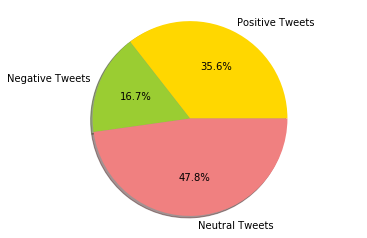

In [7]:
import re
import tweepy
from tweepy import OAuthHandler
from textblob import TextBlob
 
ptweetsperc=0.0
ntweetsperc=0.0 
netweetsperc=0.0

class TwitterClient(object):
    
    def __init__(self):
        try:

                self.auth = OAuthHandler(consumerkey, consumersecret)

                self.auth.set_access_token(accesstoken, accesstokensecret)

                self.api = tweepy.API(self.auth)
        except:
                print("Error: Authentication Failed")
   
 
    def clean_tweet(self, tweet):
       
        return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())
 
    def get_tweet_sentiment(self, tweet):
       
        
        analysis = TextBlob(self.clean_tweet(tweet))
        
        
        if analysis.sentiment.polarity > 0:
            return 'positive'
        elif analysis.sentiment.polarity == 0:
            return 'neutral'
        else:
            return 'negative'
 
    def get_tweets(self, query, count = 10):
        
       
        tweets = []
 
        try:
            
            fetched_tweets = self.api.search(q = query, count = count)
 
            
            for tweet in fetched_tweets:
                # empty dictionary to store required params of a tweet
                parsed_tweet = {}
 
                # saving text of tweet
                parsed_tweet['text'] = tweet.text
                # saving sentiment of tweet
                parsed_tweet['sentiment'] = self.get_tweet_sentiment(tweet.text)
 
                # appending parsed tweet to tweets list
                if tweet.retweet_count > 0:
                    # if tweet has retweets, ensure that it is appended only once
                    if parsed_tweet not in tweets:
                        tweets.append(parsed_tweet)
                else:
                    tweets.append(parsed_tweet)
 
            # return parsed tweets
            return tweets
 
        except tweepy.TweepError as e:
            # print error (if any)
            print("Error : " + str(e))
 
def get_sentimental_analysis():
    # creating object of TwitterClient Class
    api = TwitterClient()
    # calling function to get tweets
    tweets = api.get_tweets(query = 'cars', count = 200)
    global ptweetsperc
    
    ptweets = [tweet for tweet in tweets if tweet['sentiment'] == 'positive']
    ptweetsperc = (100*len(ptweets)/len(tweets))
    print("Positive tweets percentage: {} %".format(100*len(ptweets)/len(tweets)))
    
    global ntweetsperc
    
    ntweets = [tweet for tweet in tweets if tweet['sentiment'] == 'negative']
    ntweetsperc=(100*len(ntweets)/len(tweets))
    print("Negative tweets percentage: {} %".format(100*len(ntweets)/len(tweets)))
    
    global netweetsperc
    
    netweets = [tweet for tweet in tweets if tweet['sentiment'] == 'neutral']
    netweetsperc=(100*len(netweets)/len(tweets))
    print("Neutral tweets percentage: {} %".format(100*len(netweets)/len(tweets)))
 

get_sentimental_analysis()


labels = ['Positive Tweets','Negative Tweets','Neutral Tweets']

sizes = [ptweetsperc,ntweetsperc,netweetsperc]
colors = ['gold', 'yellowgreen', 'lightcoral']

plt.pie(sizes, labels=labels,autopct='%1.1f%%',colors=colors,shadow=True)
plt.axis('equal')
plt.show()
